In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
# import dataframe

parsed_dataset_df = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/husky/parsed_data/grass_1_full.csv')

parsed_dataset = parsed_dataset_df.to_numpy()

steady_state_mask = parsed_dataset_df['steady_state_mask'] == True
parsed_dataset_steady_state = parsed_dataset[steady_state_mask]

# cols = ['timestamp', 'imu_roll_vel', 'imu_pitch_vel', 'imu_yaw_vel', 'cmd_vx', 'cmd_omega', 
#         'icp_x', 'icp_y', 'icp_z', 'icp_roll', 'icp_pitch', 'icp_yaw', 'icp_vx', 'icp_vy', 'icp_omega',
#         'wheel_left_vel', 'wheel_right_vel', 'diff_drive_vels_x', 'diff_drive_vels_y', 'diff_drive_vels_omega', 
#         'calib_step', 'steady_state_mask']

print(parsed_dataset_df)
print(parsed_dataset_steady_state.shape)

         timestamp  imu_roll_vel  imu_pitch_vel  imu_yaw_vel  cmd_vx  \
0         0.000000      0.000000       0.000000     0.000000     0.0   
1         0.056456      0.000000       0.000000     0.000000     0.0   
2         0.106417      0.000000       0.000000     0.000000     0.0   
3         0.151805      0.000000       0.000000     0.000000     0.0   
4         0.201219     -0.000032      -0.004903    -0.000315     0.0   
...            ...           ...            ...          ...     ...   
47289  2364.451402     -0.001022       0.000108    -0.001432     0.1   
47290  2364.500847     -0.001821      -0.002145    -0.001958     0.1   
47291  2364.550206     -0.001588      -0.002174    -0.000701     0.1   
47292  2364.606586     -0.002529      -0.001212    -0.000308     0.1   
47293  2364.656759     -0.000430      -0.002226    -0.001716     0.1   

       cmd_omega      icp_x      icp_y     icp_z  icp_roll  ...        icp_vx  \
0            0.0   0.000000   0.000000  0.000000  0.00

In [35]:
# loop through dataset, find all horizons

parsed_dataset_steady_state = parsed_dataset[steady_state_mask]
print(parsed_dataset_steady_state.shape)
n_points_steady_state = parsed_dataset_steady_state.shape[0]

training_horizon = 2

horizon_starts = []
horizon_ends = []

for i in range(1, n_points_steady_state):
    if parsed_dataset_steady_state[i-1, 20] != parsed_dataset_steady_state[i, 20]:
        horizon_starts.append(i)
        horizon_elapsed = 0
        j = i
        if parsed_dataset_steady_state[j, 20] == parsed_dataset_steady_state[-1, 20]:
            horizon_starts.pop()
            break
        while parsed_dataset_steady_state[j+1, 20] == parsed_dataset_steady_state[j, 20]:
            horizon_elapsed += (parsed_dataset[j+1, 0] - parsed_dataset[j, 0])
            if horizon_elapsed >= 2.0:
                horizon_ends.append(j)
                horizon_starts.append(j+1)
                horizon_elapsed = 0
            j += 1
        horizon_starts.pop()

print(len(horizon_starts))
print(len(horizon_ends))

print(horizon_starts[638])
print(horizon_ends[638])
    

(34400, 22)
639
639
34160
34200


In [52]:
# build torch-ready wheel-encoder dataset

rate = 0.05
timesteps_per_horizon = int(training_horizon / rate)

torch_input_array = np.zeros((len(horizon_starts), 10+timesteps_per_horizon*2)) # [icp_x, icp_y, icp_yaw, vx0, vomega0, vx1, vomega1, vx2, vomega2, vx3, vomega3]
torch_output_array = np.zeros((len(horizon_starts), 6)) # [icp_x, icp_y, icp_yaw]

for i in range(0, len(horizon_starts)):
    horizon_start = horizon_starts[i]
    torch_input_array[i, :6] = parsed_dataset_steady_state[horizon_start, 6:12]
    torch_input_array[i, 6] = parsed_dataset_steady_state[horizon_start, 20]
    torch_input_array[i, 7] = parsed_dataset_steady_state[horizon_start, 4]
    torch_input_array[i, 8] = parsed_dataset_steady_state[horizon_start, 5]
#     torch_input_array[i, 9] = 1
    
    if torch_input_array[i, 8] <= 0: #and torch_input_array[i, 8] <= 0:
        torch_input_array[i, 9] = 0
    else:
        torch_input_array[i, 9] = 1
    
    for j in range(0, timesteps_per_horizon):
        torch_input_array[i, 10+j*2] = parsed_dataset_steady_state[horizon_start+j, 15]
        torch_input_array[i, 10+j*2+1] = parsed_dataset_steady_state[horizon_start+j, 16]
    torch_output_array[i, :] = parsed_dataset_steady_state[horizon_ends[i], 6:12]
    
torch_array = np.concatenate((torch_input_array, torch_output_array), axis=1)

cols = ['init_icp_x', 'init_icp_y', 'init_icp_z', 'init_icp_roll', 'init_icp_pitch', 'init_icp_yaw']
cols.append('calib_step')
cols.append('cmd_vx')
cols.append('cmd_omega')
cols.append('mask')
for i in range(0, timesteps_per_horizon):
    str_cmd_vx_i = 'cmd_left_wheel_' + str(i)
    str_cmd_omega_i = 'cmd_right_wheel_' + str(i)
    cols.append(str_cmd_vx_i)
    cols.append(str_cmd_omega_i)
cols.append('gt_icp_x')
cols.append('gt_icp_y')
cols.append('gt_icp_z')
cols.append('gt_icp_roll')
cols.append('gt_icp_pitch')
cols.append('gt_icp_yaw')

torch_dataset_df = pd.DataFrame(torch_array, columns = cols)
torch_dataset_df.to_pickle('/home/dominic/repos/norlab_WMRD/data/husky/masked_datasets/grass_1_right.csv')

print(torch_dataset_df)

     init_icp_x  init_icp_y  init_icp_z  init_icp_roll  init_icp_pitch  \
0      1.012477   15.459271   -0.206953      -0.014097        0.005596   
1      0.470085   16.733973   -0.205989      -0.019562        0.022385   
2     -0.525775   17.687853   -0.185594      -0.027426        0.016527   
3     -3.952225   17.789022   -0.094262       0.031605        0.053115   
4     -4.462355   16.993017   -0.064404       0.010496        0.031299   
..          ...         ...         ...            ...             ...   
634  -18.067970   23.864222   -0.041522       0.022923       -0.032532   
635  -18.009340   23.414803   -0.020184       0.029014       -0.003202   
636  -17.307983   28.173689   -0.005993      -0.011654        0.006429   
637  -16.765856   28.187654   -0.054634      -0.006683       -0.018721   
638  -16.205238   27.868204   -0.069717       0.004665       -0.003175   

     init_icp_yaw  calib_step  cmd_vx  cmd_omega  mask  ...  \
0       -1.366977         1.0    -2.0   0.416667

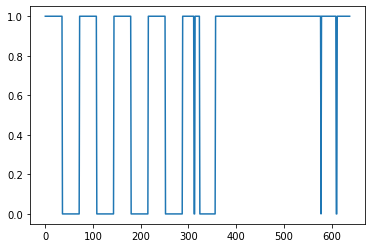

In [48]:
plt.plot(torch_input_array[:, 9])

In [36]:
# experiment params

max_lin_speed = 2.0
lin_step = 0.5
max_ang_vel = 2.5
ang_steps = 12
ang_inc = 2 * max_ang_vel / ang_steps
print(ang_inc)

n_lin_steps = int(2 * max_lin_speed / lin_step) + 1

# create velocity array mask

full_vels_array = np.zeros((n_lin_steps, ang_steps+1, 2))

for i in range(0, n_lin_steps):
    full_vels_array[i, :, 0] = -max_lin_speed + i*lin_step
    full_vels_array[i, 0, 1] = - max_ang_vel
    for j in range(1, ang_steps+1):
        full_vels_array[i,j, 1] = -max_ang_vel + j*ang_inc
        
print(full_vels_array[:,:,0])
print(full_vels_array[:,:,1])

0.4166666666666667


In [20]:
# create velocity mask array

vel_mask_array = np.full((full_vels_array.shape[0], full_vels_array.shape[1]), True)

for i in range(0, full_vels_array.shape[0]):
    for j in range(0, full_vels_array.shape[1]):
        if full_vels_array[i,j,0] >= 0 and full_vels_array[i,j,1] <= 0:
            vel_mask_array[i,j] = False
            
np.save('/home/dominic/repos/norlab_WMRD/data/husky/vel_mask_array_all.npy', vel_mask_array)

In [21]:
masked_vel_array = full_vels_array[vel_mask_array]

print(full_vels_array.shape)
print(masked_vel_array.shape)

print()

(9, 13, 2)
(117, 2)
